# Differentially expressed gene analysis for developing human hearts

In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
import anndata as ad
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.image import imread
import os
import sys
import scipy.stats as st

import warnings
warnings.filterwarnings("ignore")

## Load STitch3D results

In [2]:
adata_st_list_6pcw = []

for i in range(9):
    adata_st_i = sc.read_h5ad("./results_human_heart/res_adata_slice%d.h5ad" % i)
    adata_st_i.var_names_make_unique()
    adata_st_i = adata_st_i[:, np.array(~adata_st_i.var.index.isna())
                             & np.array(~adata_st_i.var_names.str.startswith("mt-"))
                             & np.array(~adata_st_i.var_names.str.startswith("MT-"))]
    adata_st_list_6pcw.append(adata_st_i)

In [3]:
adata_st_list_9pcw = []

for i in range(6):
    adata_st_i = sc.read_h5ad("./results_9PCW/res_adata_slice%d.h5ad" % i)
    adata_st_i.var_names_make_unique()
    adata_st_i = adata_st_i[:, np.array(~adata_st_i.var.index.isna())
                             & np.array(~adata_st_i.var_names.str.startswith("mt-"))
                             & np.array(~adata_st_i.var_names.str.startswith("MT-"))]
    adata_st_list_9pcw.append(adata_st_i)

## Locate smooth muscle cell-enriched regions and visualize in 2D

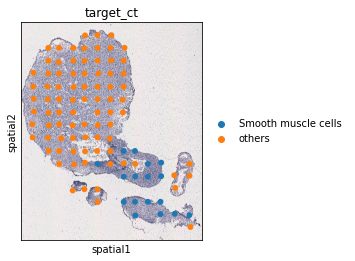

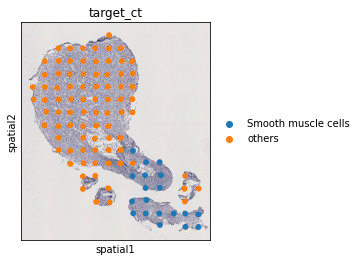

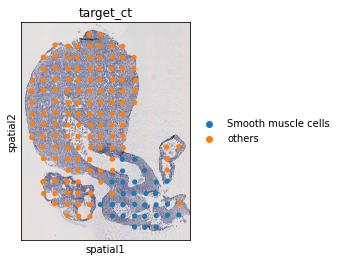

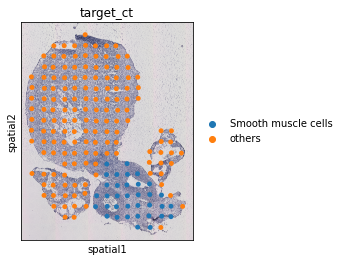

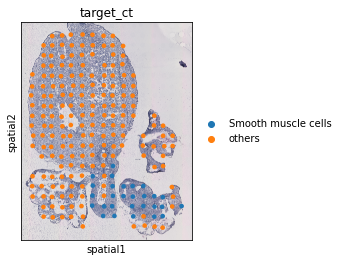

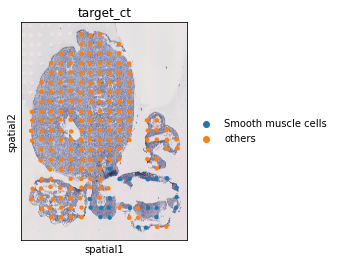

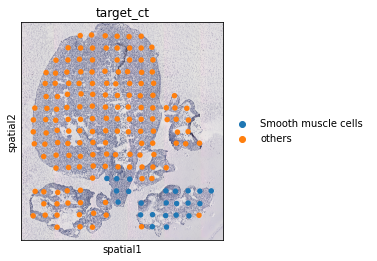

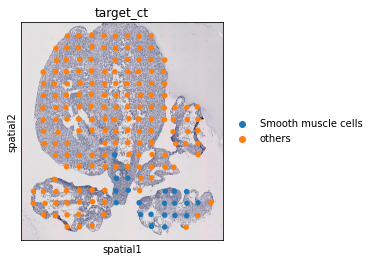

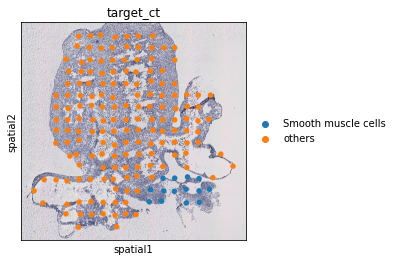

In [4]:
ct = 'Smooth muscle cells '

#6pcw
for i in range(9):
    idx = (adata_st_list_6pcw[i].obs[ct] > 0.2)
    adata_st_list_6pcw[i].obs["target_ct"] = "others"
    adata_st_list_6pcw[i].obs["target_ct"][idx] = ct
    sc.pl.spatial(adata_st_list_6pcw[i], img_key="hires", color="target_ct", size=1.)

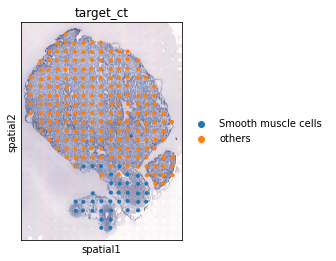

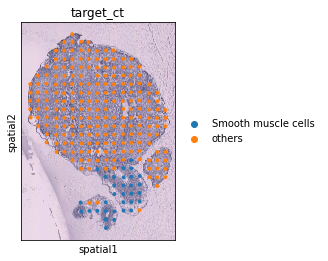

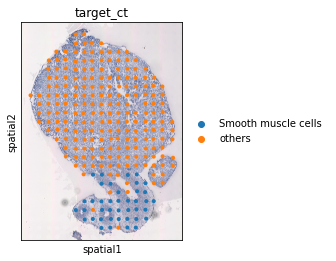

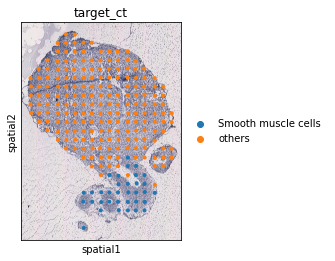

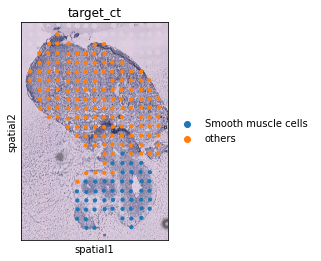

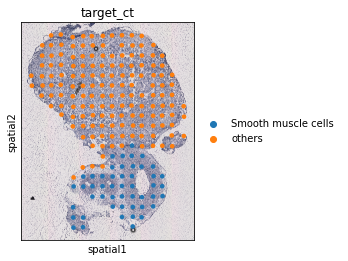

In [5]:
#9pcw
for i in range(6):
    idx = (adata_st_list_9pcw[i].obs[ct] > 0.2)
    adata_st_list_9pcw[i].obs["target_ct"] = "others"
    adata_st_list_9pcw[i].obs["target_ct"][idx] = ct
    sc.pl.spatial(adata_st_list_9pcw[i], img_key="hires", color="target_ct", size=1.)

In [6]:
for i in range(9):
    adata_st_i = adata_st_list_6pcw[i]
    if i==0:
        gene_list = list(adata_st_i.var.index)
    else:
        gene_list = sorted(list(set(gene_list) & set(adata_st_i.var.index)))
        
for i in range(9):
    adata_st_list_6pcw[i].obs.index = adata_st_list_6pcw[i].obs.index.astype(str)
    adata_st_list_6pcw[i] = adata_st_list_6pcw[i][:, gene_list]
    if i ==0:
        adata_6pcw = adata_st_list_6pcw[i].copy()
    else:
        adata_6pcw = ad.concat([adata_6pcw, adata_st_list_6pcw[i]])

In [7]:
for i in range(6):
    adata_st_i = adata_st_list_9pcw[i]
    if i==0:
        gene_list = list(adata_st_i.var.index)
    else:
        gene_list = sorted(list(set(gene_list) & set(adata_st_i.var.index)))
        
for i in range(6):
    adata_st_list_9pcw[i].obs.index = adata_st_list_9pcw[i].obs.index.astype(str)
    adata_st_list_9pcw[i] = adata_st_list_9pcw[i][:, gene_list]
    if i ==0:
        adata_9pcw = adata_st_list_9pcw[i].copy()
    else:
        adata_9pcw = ad.concat([adata_9pcw, adata_st_list_9pcw[i]])

In [8]:
sc.pp.normalize_total(adata_9pcw, target_sum=1e4)
sc.pp.log1p(adata_9pcw)

sc.pp.normalize_total(adata_6pcw, target_sum=1e4)
sc.pp.log1p(adata_6pcw)

## Select highly expressed genes in smooth muscle cell-enriched regions

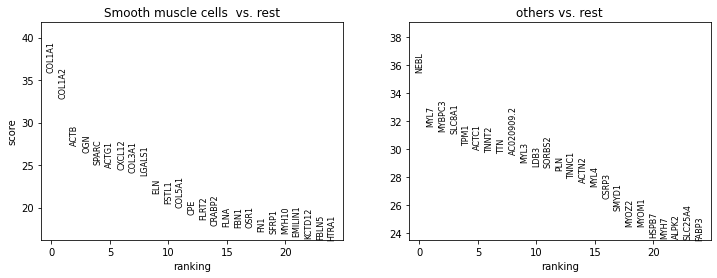

In [9]:
sc.tl.rank_genes_groups(adata_6pcw, groupby="target_ct", method="t-test", key_added="ttest")
sc.tl.rank_genes_groups(adata_6pcw, groupby="target_ct", method="t-test")
sc.pl.rank_genes_groups(adata_6pcw, n_genes=25, sharey=False)

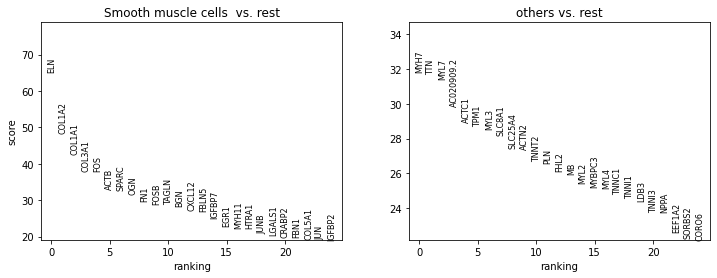

In [10]:
sc.tl.rank_genes_groups(adata_9pcw, groupby="target_ct", method="t-test", key_added="ttest")
sc.tl.rank_genes_groups(adata_9pcw, groupby="target_ct", method="t-test")
sc.pl.rank_genes_groups(adata_9pcw, n_genes=25, sharey=False)

In [11]:
result = adata_6pcw.uns['ttest']
groups = result['names'].dtype.names
df_genes_all = pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'scores']}).head(100)
markers_6pcw = df_genes_all["Smooth muscle cells _n"].values.astype(str)

result = adata_9pcw.uns['ttest']
groups = result['names'].dtype.names
df_genes_all = pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'scores']}).head(100)
markers_9pcw = df_genes_all["Smooth muscle cells _n"].values.astype(str)

markers = sorted(list(set(gene_list) & (set(markers_6pcw) | set(markers_9pcw))))
len(markers)

132

In [12]:
for i in range(9):
    adata_st_list_6pcw[i].obs["PCW"] = "6PCW"
    if i ==0:
        adata_all = adata_st_list_6pcw[i][adata_st_list_6pcw[i].obs["target_ct"].values.astype(str)==ct, markers].copy()
    else:
        adata_all = ad.concat([adata_all, adata_st_list_6pcw[i][adata_st_list_6pcw[i].obs["target_ct"].values.astype(str)==ct, markers]])
        
for i in range(6):
    adata_st_list_9pcw[i].obs["PCW"] = "9PCW"
    adata_all = ad.concat([adata_all, adata_st_list_9pcw[i][adata_st_list_9pcw[i].obs["target_ct"].values.astype(str)==ct, markers]])

## Find differentially expressed genes between 6 PCW and 9 PCW hearts

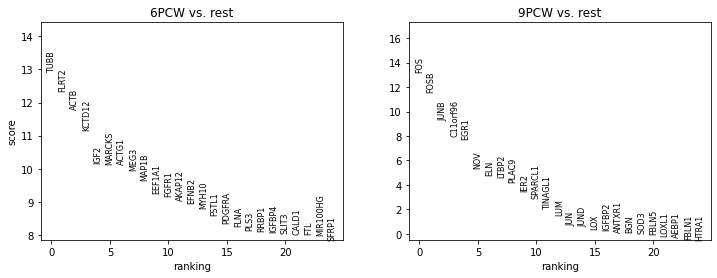

In [13]:
sc.tl.rank_genes_groups(adata_all, groupby="PCW", method="t-test")
sc.pl.rank_genes_groups(adata_all, n_genes=25, sharey=False)

In [14]:
result = adata_all.uns['rank_genes_groups']
groups = result['names'].dtype.names
df_genes_all = pd.DataFrame(
    {group + '_' + key: result[key][group]
    for group in groups for key in ['names', 'scores', 'pvals']}).head(10)

In [15]:
df_genes_all

,6PCW_names,6PCW_scores,6PCW_pvals,9PCW_names,9PCW_scores,9PCW_pvals
0,TUBB,12.906939,5.374710e-30,FOS,13.190381,3.903214e-33
1,FLRT2,12.339162,5.400342e-27,FOSB,11.562020,1.310036e-26
2,ACTB,11.799377,1.980442e-26,JUNB,9.279203,1.218486e-18
3,KCTD12,11.171007,1.996450e-23,C11orf96,7.974435,1.863454e-14
4,IGF2,10.159365,2.241748e-20,EGR1,7.728141,7.250930e-14
5,MARCKS,10.139724,2.038758e-20,NOV,5.400161,1.220504e-07
6,ACTG1,10.124864,6.185292e-21,ELN,4.767730,2.516882e-06
7,MEG3,9.949177,6.072190e-20,LTBP2,4.655122,4.393786e-06
8,MAP1B,9.665799,2.899559e-19,PLAC9,4.191800,3.339096e-05
9,EEF1A1,9.253819,4.269983e-18,IER2,3.474742,5.609090e-04
